In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import wandb
import numpy as np
import torch
import pandas as pd
import evaluate
import ast

In [2]:
api = wandb.Api()

In [3]:
def download_predictions(run_name: str, invert:bool = False) -> tuple[dict]:
    ret = []

    wandb_project_base = 'redstag/thesis'
    api = wandb.Api()
    runs = api.runs(path=wandb_project_base, filters={"display_name": run_name})

    for run in runs:
        if run.state == 'finished':
            for art in run.logged_artifacts():
                if "test_predictions" in art.name:
                    path = art.download()
                    labels = np.load(path + '/labels.npy')
                    predictions = np.load(path + '/predictions.npy')
                    # Apply softmax to prediction logits using torch
                    predictions_t = torch.tensor(predictions)
                    probs = torch.nn.functional.softmax(predictions_t, dim=-1)
                    predictions = torch.argmax(probs, dim=1, keepdim=True).flatten().numpy()

                    # Invert if desired
                    if invert:
                        predictions = np.abs(predictions - 1)

                    ret.append({
                        'run_name': run_name,
                        'artifact_name': art.name,
                        'predictions': predictions,
                        'labels': labels})
    
    return tuple(ret)

In [4]:
def get_logged_f1(run_name: str) -> np.array:
    wandb_project_base = 'redstag/thesis'
    api = wandb.Api()
    runs = api.runs(path=wandb_project_base, filters={"display_name": run_name})
    f1s = []

    for run in runs:
        if "test/f1" in run.summary:
            f1s.append(run.summary["test/f1"])
    
    return np.array(f1s)

In [5]:
def plot_predictions(predictions: dict):
    conf_mats = [confusion_matrix(preds["labels"], preds["predictions"]) for preds in predictions]
    fig, axes = plt.subplots(1, len(conf_mats), figsize=(15, 5))
    fig.suptitle(predictions[0]["run_name"], fontsize=16)

    if len(conf_mats) == 1:
        # Wrap in array if single axes so we can iter
        axes = [axes]

    for ax, cm, preds in zip(axes, conf_mats, predictions):
        disp = ConfusionMatrixDisplay(cm)
        disp.plot(ax=ax)
        ax.title.set_text(preds['artifact_name'])

    plt.tight_layout()
    plt.show()

In [6]:
def calculate_metrics(predictions: dict):
    metric = evaluate.combine(["precision", "recall", "accuracy", "f1"])
    metrics = [metric.compute(predictions=preds["predictions"], references=preds["labels"]) for preds in predictions]
    
    return pd.DataFrame(metrics)

In [7]:
def get_misclassified_samples(predictions: np.array, data_frame: pd.DataFrame, trunc_data: int | bool = False):
    if trunc_data:
        data_frame = data_frame.head(trunc_data)
    
    # Convert the "class_label" column to integers (Yes -> 1, No -> 0)
    data_frame['class_label'] = data_frame['class_label'].map({'Yes': 1, 'No': 0})
    
    # Retrieve rows where the "class_label" column does not match the predictions
    misclassified_samples = data_frame[data_frame['class_label'] != predictions]
    
    return misclassified_samples

In [8]:
def plot_misclassifications(misclassified: pd.DataFrame, plot_header: str | None = None):
    columns_to_plot = ["topic", "style", "source", "class_label", "sentiment"]

    fig, axes = plt.subplots(2, 3, figsize=(8, 6))

    if plot_header:
        fig.suptitle(plot_header, fontsize=16)

    axes = axes.flatten()

    for idx, col in enumerate(columns_to_plot):
        misclassified[col].value_counts().plot(kind='bar', ax=axes[idx], title=f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
    
    # Handle NER
    ner_counts = {}
    for tags in misclassified['ner'].dropna():
        for t in tags:
            if t in ner_counts:
                ner_counts[t] += 1
            else:
                ner_counts[t] = 1
    
    # Plot NER tag distribution as a histogram in the last subplot
    plt.tight_layout()
    plt.show()

    # Plot NER tag distribution in a separate figure
    if ner_counts:
        # Sort ner_counts by descending value
        sorted_ner = sorted(ner_counts.items(), key=lambda x: x[1], reverse=True)
        ner_tags, ner_values = zip(*sorted_ner)
        plt.figure(figsize=(6, 4))
        plt.bar(ner_tags, ner_values)
        plt.title('NER Tag Distribution')
        plt.xlabel('NER Tag')
        plt.ylabel('Count')
        plt.xticks(rotation=60)
        plt.tight_layout()
        plt.show()
    

    plt.tight_layout()
    plt.show()

In [9]:
from collections import Counter

def intersect_misclassifications(misclassified: list[pd.DataFrame], min_num_misclassified: int) -> pd.DataFrame:
    # Combine all misclassified dataframes into a single dataframe
    combined = pd.concat(misclassified, ignore_index=True)
    
    # Count occurrences of each Sentence_id across all dataframes
    counts = combined['Sentence_id'].value_counts()
    
    # Filter Sentence_ids that appear in at least min_num_misclassified dataframes
    frequent_ids = counts[counts >= min_num_misclassified].index
    
    # Retrieve rows with those Sentence_ids
    result = combined[combined['Sentence_id'].isin(frequent_ids)]

    # Remove duplicate rows based on 'Sentence_id', keeping the first occurrence
    result = result.drop_duplicates(subset='Sentence_id')
    
    return result

def exclusive_misclassifications(misclassified_left: pd.DataFrame, misclassified_right: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    intersection = intersect_misclassifications([misclassified_left, misclassified_right], min_num_misclassified=2)
    exclusive_left = misclassified_left[~misclassified_left['Sentence_id'].isin(intersection['Sentence_id'])]
    exclusive_right = misclassified_right[~misclassified_right['Sentence_id'].isin(intersection['Sentence_id'])]
    
    return exclusive_left, exclusive_right

In [53]:
def strip_plot_f1(title: str, f1_data: dict):
    """
    Plot a strip plot of F1 scores for various datasets.

    Args:
        title (str): Title of the plot.
        f1_data (dict): Dictionary where keys are dataset names (str) and
                        values are numpy arrays of F1 scores (float).
    """
    datasets = list(f1_data.keys())
    fig, ax = plt.subplots(figsize=(7, 1 + len(datasets) * 0.3))
    
    # Use a single color for all dots
    dot_color = 'tab:blue'
    for i, dataset in enumerate(datasets):
        y_vals = np.full_like(f1_data[dataset], fill_value=i, dtype=float)
        run_scatter = ax.scatter(f1_data[dataset], y_vals, s=30, color=dot_color, alpha=0.65)
        # Plot the mean F1 score as a smaller dot
        mean_f1 = np.mean(f1_data[dataset])
        mean_scatter = ax.scatter(mean_f1, i, s=60, color='orange', marker='+')

        # Add legend
        if i == 0:
            ax.legend([run_scatter, mean_scatter], ["Single run", "Mean"])

    all_f1 = np.concatenate(list(f1_data.values()))
    min_f1 = np.min(all_f1)
    max_f1 = np.max(all_f1)
    x_start = max(0, min_f1 - 0.05)
    x_end = min(1, max_f1 + 0.05)

    ax.set_yticks(np.arange(len(datasets)))
    ax.set_yticklabels(datasets)
    ax.set_xlabel("F1")
    ax.set_ylabel("Dataset")
    ax.set_xlim(x_start, x_end)
    ax.set_title(title)
    ax.invert_yaxis()  # Optional: to match visual style
    plt.grid(axis='both', linestyle='--', alpha=0.85)
    plt.tight_layout()
    plt.show()

In [11]:
datasets = [
    "real_synth_10k_0_general_claim_eval",
    "real_synth_8k_2k_general_claim_eval",
    "real_synth_6k_4k_general_claim_eval",
    "real_synth_4k_6k_general_claim_eval",
    "real_synth_2k_8k_general_claim_eval",
    "real_synth_0_10k_general_claim_eval",
    ]

datasets_ct24 = [
    "real_synth_10k_0",
    "real_synth_8k_2k",
    "real_synth_6k_4k",
    "real_synth_4k_6k",
    "real_synth_2k_8k",
    "real_synth_0_10k",
    ]

In [12]:
invert = False
predictions = [download_predictions(d, invert=invert) for d in datasets]

wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  


In [13]:
metrics = [calculate_metrics(p) for p in predictions]

In [14]:
# for p, m in zip(predictions, metrics):
#     plot_predictions(p)
#     print(m)
#     print("--mean--")
#     print(m.mean())

In [15]:
strip_plot_gc_data = {d.replace("_general_claim_eval", ""): m["f1"] for d, m in zip(datasets, metrics)}
strip_plot_ct_data = {d: get_logged_f1(d) for d in datasets_ct24}

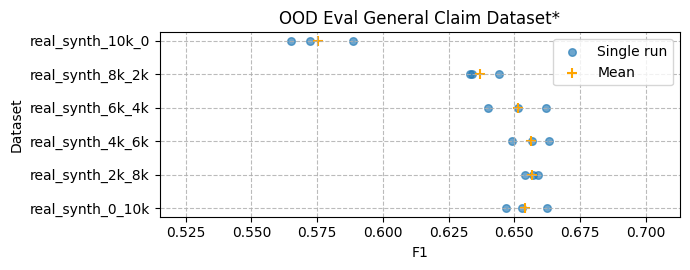

In [59]:
strip_plot_f1("OOD Eval General Claim Dataset*", strip_plot_gc_data)

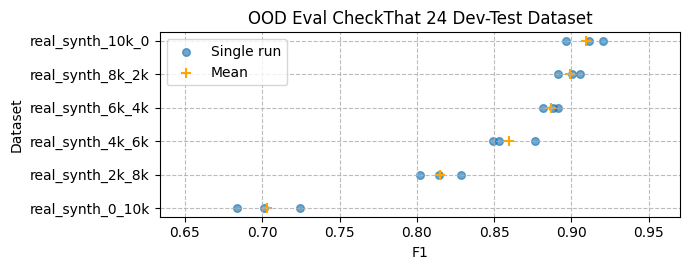

In [60]:
strip_plot_f1("OOD Eval CheckThat 24 Dev-Test Dataset", strip_plot_ct_data)

In [18]:
#plot_predictions(download_predictions("ct24_general_claim_eval", invert=invert))
#plot_predictions(download_predictions("ct24_double_general_claim_eval", invert=invert))

In [27]:
api = wandb.Api()
artifact = api.artifact("redstag/thesis/general_claim_tagged:latest")
eval_df = pd.read_csv(f"{artifact.download()}/tagged_data.csv")

wandb: Downloading large artifact general_claim_tagged:latest, 64.53MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (98.2MB/s)


In [28]:
# Convert the NER string to a list
eval_df['ner'] = eval_df['ner'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)

In [29]:
#misclassified_ct24 = [get_misclassified_samples(preds["predictions"], eval_df, trunc_data=len(preds["predictions"])) for preds in predictions_ct24]
#misclassified_ct24_double = [get_misclassified_samples(preds["predictions"], eval_df, trunc_data=len(preds["predictions"])) for preds in predictions_ct24_double]

In [30]:
#majority_misclassified_ct24 = intersect_misclassifications(misclassified_ct24, min_num_misclassified=1)
#majority_misclassified_ct24_double = intersect_misclassifications(misclassified_ct24_double, min_num_misclassified=1)

In [31]:
#exclusive_ct24, exclusive_ct24_double = exclusive_misclassifications(majority_misclassified_ct24, majority_misclassified_ct24_double)

In [32]:
#plot_misclassifications(exclusive_ct24, "CT24 exclusive misclassification distribution")
#plot_misclassifications(exclusive_ct24_double, "CT24 double exclusive misclassification distribution")